In this cell, we installed the `KeyBERT` library. It helps extract important keywords from text using deep learning models.

In [ ]:
pip install keybert

In this cell, I imported the required libraries:

- `zipfile`, `os`: For file and folder operations.
- `pandas`: To load and work with tabular data.
- `matplotlib.pyplot`, `seaborn`: For visualizing the dataset.
- `pickle`: To load saved models or data.
- `sentence_transformers`, `keybert`: For working with text embeddings and extracting keywords.

In [ ]:
import zipfile
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sentence_transformers import SentenceTransformer
from keybert import KeyBERT

In [ ]:
!pip freeze > requirements.txt

# download & preprocess data

This cell defines two functions:

1. `unzip_archive()`: Unzips the dataset from a .zip file and extracts it to a folder.
2. `preprocess_news()`: Loads the `news.tsv` file, combines the title and abstract into one `content` column, and saves the cleaned data to a CSV file (`news_preprocessed.csv`) for easier use later.

At the end, both functions are called to execute the extraction and preprocessing steps.

In [ ]:
# Unzip the MIND dataset and preprocess the news.tsv file
# This extracts the archive and combines the title and abstract into one 'content' column.
def unzip_archive(zip_path='/content/archive.zip', extract_to='/content/data'):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"Archive extracted to '{extract_to}'")

# The cleaned data is saved to news_preprocessed.csv for use in modeling and analysis.
def preprocess_news(input_path='/content/data/MINDsmall_train/news.tsv', output_path='/content/data/news_preprocessed.csv'):
    df = pd.read_table(input_path, header=None)
    df.columns = ['news_id', 'category', 'subcategory', 'title', 'abstract', 'url', 'title_entities', 'abstract_entities']
    df['content'] = df['title'].fillna('') + '. ' + df['abstract'].fillna('')
    df[['news_id', 'category', 'subcategory', 'content']].to_csv(output_path, index=False)
    print(f"Preprocessed data saved to '{output_path}'")

# Run
unzip_archive()
preprocess_news()

Archive extracted to '/content/data'
Preprocessed data saved to '/content/data/news_preprocessed.csv'


In [ ]:
# Load preprocessed data
df = pd.read_csv('/content/data/news_preprocessed.csv')
df.head()

,news_id,category,subcategory,content
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an..."
1,N19639,health,weightloss,50 Worst Habits For Belly Fat. These seemingly...
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...
3,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...
4,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De..."


This cell creates a bar chart showing how many news articles exist in each main category.  
It helps us understand the distribution of the data across different categories.

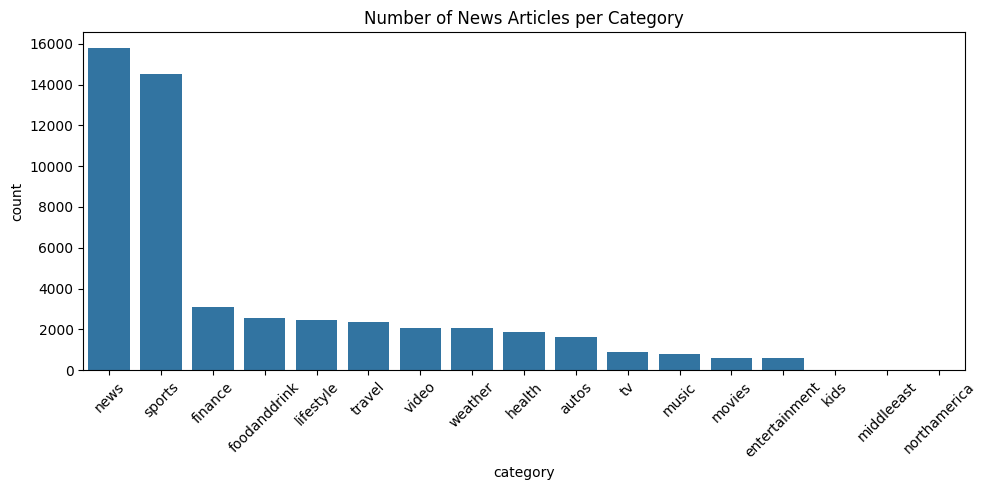

In [ ]:
# Plot the number of news articles for each main category
plt.figure(figsize=(10,5))
sns.countplot(data=df, x='category', order=df['category'].value_counts().index)
plt.title('Number of News Articles per Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

This cell shows a bar chart of the top 10 most common subcategories in the dataset.  
It helps visualize which topics appear most frequently in the news data.

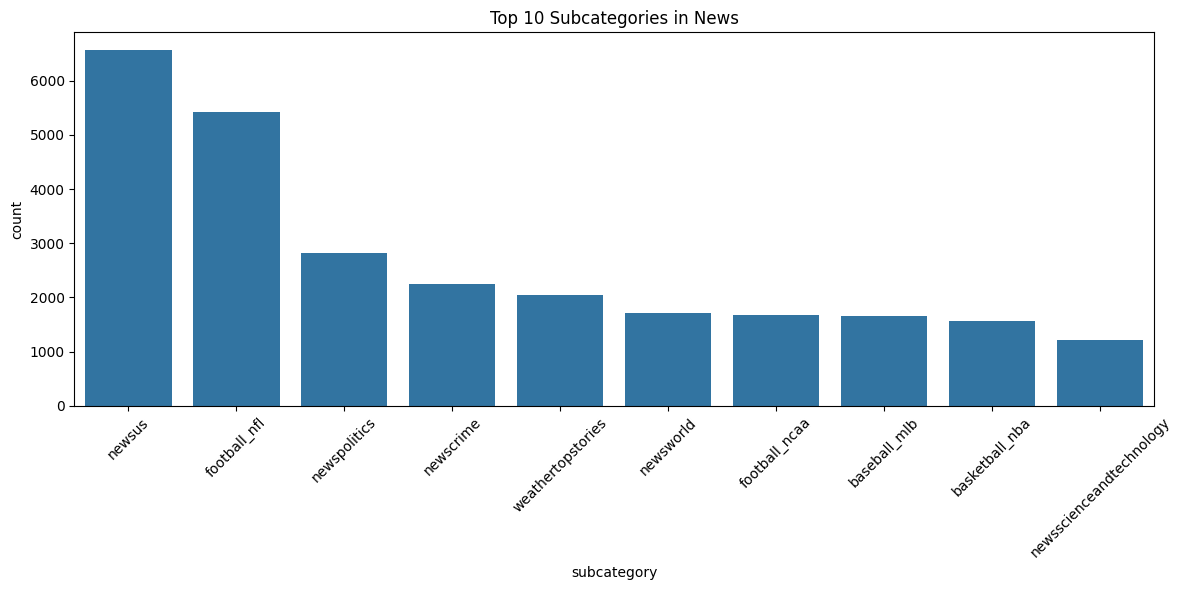

In [ ]:
# Visualize the top 10 most frequent subcategories in the dataset
plt.figure(figsize=(12,6))
top_subs = df['subcategory'].value_counts().nlargest(10).index
sns.countplot(data=df[df['subcategory'].isin(top_subs)], x='subcategory', order=top_subs)
plt.title('Top 10 Subcategories in News')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Training functions

This cell defines and runs two main training functions:

1.train_and_save_embeddings():  
   Uses the `SentenceTransformer` model to generate sentence embeddings for each news article's content, and saves them to a `.pkl` file for later use.

2.extract_and_save_keywords():  
   Uses the `KeyBERT` model to extract the top 5 important keywords or phrases from each article, and also saves the result.

Both are executed at the end to prepare the data for use in recommendations or search.

In [ ]:
# train_models.py

import pandas as pd
import pickle
from sentence_transformers import SentenceTransformer
from keybert import KeyBERT

# --- Train Content-Based Embeddings ---
def train_and_save_embeddings(news_path='data/news_preprocessed.csv',
                               output_path='data/news_embeddings.pkl'):
    df = pd.read_csv(news_path)
    model = SentenceTransformer('all-MiniLM-L6-v2')
    embeddings = model.encode(df['content'].tolist(), show_progress_bar=True)
    with open(output_path, 'wb') as f:
        pickle.dump(embeddings, f)
    print(f"✅ Saved BERT embeddings to {output_path}")

# --- Train Keyword Extraction ---
def extract_and_save_keywords(news_path='data/news_preprocessed.csv',
                               output_path='data/news_keywords.pkl',
                               top_n=5):
    df = pd.read_csv(news_path)
    model = KeyBERT('all-MiniLM-L6-v2')
    all_keywords = []
    for content in df['content']:
        keywords = model.extract_keywords(content, keyphrase_ngram_range=(1,2), stop_words='english', top_n=top_n)
        keyword_list = [kw for kw, _ in keywords]
        all_keywords.append(keyword_list)
    with open(output_path, 'wb') as f:
        pickle.dump(all_keywords, f)
    print(f"✅ Saved extracted keywords to {output_path}")

# --- Main Execution ---
if __name__ == "__main__":
    train_and_save_embeddings()
    extract_and_save_keywords()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1603 [00:00<?, ?it/s]

✅ Saved BERT embeddings to data/news_embeddings.pkl
✅ Saved extracted keywords to data/news_keywords.pkl


# Inference code

This code defines the recommendation system.

1.Utility Functions:
   - `clean_user_input()`: Cleans and normalizes the user's text.
   - `load_embeddings()` and `load_keywords()`: Load the saved data (embeddings or keywords) from previous steps.

2. Recommendation Functions:
   - `recommend_content()`: Uses BERT embeddings to find news articles semantically similar to the user’s input.
   - `recommend_keyword()`: Finds articles based on matching user input with extracted keywords.

3. Main Execution:
   - Loads the data and model.
   - Asks the user for input and their preferred model type.
   - Shows the top 5 recommended articles with similarity scores.


In [ ]:
import re
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
def clean_user_input(text):
    """Normalize user input: lowercase, remove special characters."""
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

def load_embeddings(path='data/news_embeddings.pkl'):
    """Load content-based embeddings."""
    with open(path, 'rb') as f:
        embeddings = pickle.load(f)
    return embeddings

def load_keywords(path='data/news_keywords.pkl'):
    """Load keyword extraction lists."""
    with open(path, 'rb') as f:
        keywords = pickle.load(f)
    return keywords

# === RECOMMENDATION FUNCTIONS ===

def recommend_content(user_input, model, embeddings, df, top_n=5):
    """Recommend based on BERT semantic embeddings."""
    cleaned_input = clean_user_input(user_input)
    user_vector = model.encode([cleaned_input])[0]
    sim_scores = cosine_similarity([user_vector], embeddings)[0]
    top_indices = np.argsort(sim_scores)[-top_n:][::-1]
    return df.iloc[top_indices]['content'].tolist(), sim_scores[top_indices]

def recommend_keyword(user_input, news_keywords, df, top_n=5):
    """Recommend based on keyword matching."""
    cleaned_input = clean_user_input(user_input)
    scores = []
    for keywords in news_keywords:
        match_count = sum(1 for kw in keywords if kw.lower() in cleaned_input)
        scores.append(match_count)
    top_indices = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)[:top_n]
    return df.iloc[top_indices]['content'].tolist(), [scores[i] for i in top_indices]

# === MAIN BLOCK ===

if __name__ == "__main__":
    # TRAIN MODE


    # TEST INFERENCE (OPTIONAL)
    model = SentenceTransformer('all-MiniLM-L6-v2')
    df = pd.read_csv('data/news_preprocessed.csv')
    embeddings = load_embeddings()
    news_keywords = load_keywords()

    user_input = input("Enter your interests: ")
    model_choice = input("Choose model (content_based/keyword): ")

    if model_choice == 'content_based':
        articles, scores = recommend_content(user_input, model, embeddings, df)
    elif model_choice == 'keyword':
        articles, scores = recommend_keyword(user_input, news_keywords, df)
    else:
        print("Invalid model choice.")
        articles, scores = [], []

    for i, article in enumerate(articles):
        print(f"\nArticle {i+1}:")
        print(f"Content: {article}")
        print(f"Score: {scores[i]:.4f}")

Enter your interests: sport
Choose model (content_based/keyword): keyword

Article 1:
Content: The Brands Queen Elizabeth, Prince Charles, and Prince Philip Swear By. Shop the notebooks, jackets, and more that the royals can't live without.
Score: 0.0000

Article 2:
Content: 50 Worst Habits For Belly Fat. These seemingly harmless habits are holding you back and keeping you from shedding that unwanted belly fat for good.
Score: 0.0000

Article 3:
Content: The Cost of Trump's Aid Freeze in the Trenches of Ukraine's War. Lt. Ivan Molchanets peeked over a parapet of sand bags at the front line of the war in Ukraine. Next to him was an empty helmet propped up to trick snipers, already perforated with multiple holes.
Score: 0.0000

Article 4:
Content: I Was An NBA Wife. Here's How It Affected My Mental Health.. I felt like I was a fraud, and being an NBA wife didn't help that. In fact, it nearly destroyed me.
Score: 0.0000

Article 5:
Content: How to Get Rid of Skin Tags, According to a Derm

In [ ]:
# 📦 Install memory profiler (if not already installed)
!pip install -q memory_profiler

import pandas as pd
import time
import os
from pathlib import Path
from memory_profiler import memory_usage


# Analyzing performance

This cell analyzes the performance of the news preprocessing step.

It shows:
- ⏱️ How long the function took to run.
- 📈 The peak memory usage during processing.
- 🧾 How many rows were processed from the dataset.
- 🗃️ The final size of the output file.

This helps evaluate the efficiency of our preprocessing pipeline.

In [ ]:
def analyze_preprocess_performance(input_path='/content/data/MINDsmall_train/news.tsv', output_path='/content/data/news_preprocessed.csv'):
    """Analyze memory and time used for preprocessing."""
    print("📊 Running performance analysis...\n")
    start_time = time.time()

    mem_usage, result_df = memory_usage(
        (preprocess_news, (), {'input_path': input_path, 'output_path': output_path}),
        retval=True, interval=0.1, timeout=None
    )

    end_time = time.time()
    elapsed_time = end_time - start_time
    peak_memory = max(mem_usage)

    print(f"\n✅ Completed preprocessing")
    print(f"⏱️ Time taken       : {elapsed_time:.2f} seconds")
    print(f"📈 Peak memory usage: {peak_memory:.2f} MB")

    if result_df is not None:
        print(f"🧾 Rows processed   : {len(result_df):,}")
        print(f"🗃️ Output file size : {os.path.getsize(output_path) / (1024*1024):.2f} MB")

# === MAIN EXECUTION ===

analyze_preprocess_performance()

📊 Running performance analysis...

Preprocessed data saved to '/content/data/news_preprocessed.csv'

✅ Completed preprocessing
⏱️ Time taken       : 1.28 seconds
📈 Peak memory usage: 2152.22 MB


# Interface

In [ ]:
!pip install flask-ngrok sentence-transformers scikit-learn
!pip install flask pyngrok
!ngrok config add-authtoken # your nkrok

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


### 📰 Smart News Recommender (Flask App)

This is the full implementation of the web-based news recommender using **Flask**.

- It loads the preprocessed news dataset, BERT embeddings, and extracted keywords.
- The user enters a topic of interest and selects a model:
  - `Content-Based`: Uses BERT embeddings to find semantically similar articles.
  - `Keyword-Based`: Matches the input with extracted keywords from each article.
- The app shows results and allows interactions (👍 Like, 👎 Dislike, ⭐ Bookmark).
- Feedback is saved in a JSON file to:
  - Adjust future recommendations.
  - Calculate user satisfaction rate (likes vs. dislikes).
- The interface is styled using Tailwind CSS.
- `pyngrok` is used to share the app online via a public link.

This app brings together model inference, user feedback, and performance tracking in a simple Flask interface.

In [ ]:
from flask import Flask, request, render_template_string, redirect, url_for
from pyngrok import ngrok
import pandas as pd
import pickle, json, os
import re
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# Safe delete old user data
if os.path.exists('user_data.json'):
    os.remove('user_data.json')

# Load models and data
model = SentenceTransformer('all-MiniLM-L6-v2')
df = pd.read_csv('/content/data/news_preprocessed.csv')
with open('/content/data/news_embeddings.pkl', 'rb') as f:
    embeddings = pickle.load(f)
with open('/content/data/news_keywords.pkl', 'rb') as f:
    news_keywords = pickle.load(f)

DATA_FILE = "user_data.json"
if not os.path.exists(DATA_FILE):
    with open(DATA_FILE, 'w') as f:
        json.dump({"bookmarks": [], "likes": [], "dislikes": [], "performance": {"likes_count": 0, "dislikes_count": 0}}, f)

# --- Global Memory for last session ---
last_query = ""
last_model_type = ""

app = Flask(__name__)

# --- HTML Templates ---
HTML_TEMPLATE = '''
<!DOCTYPE html>
<html lang="en">
<head>
  <meta charset="UTF-8">
  <title>Smart News Recommender</title>
  <script src="https://cdn.tailwindcss.com"></script>
  <style>
    body { font-family: 'Inter', sans-serif; }
  </style>
</head>
<body class="bg-gradient-to-tr from-blue-100 to-blue-50 min-h-screen p-6">
  <div class="max-w-3xl mx-auto bg-white shadow-2xl rounded-xl p-8 mt-10">
    <h1 class="text-4xl font-bold text-center text-blue-800 mb-2">Smart News Recommender</h1>
    <p class="text-center text-gray-600 mb-6">Discover news tailored to your interests using AI</p>

    <form method="POST" class="space-y-4">
      <textarea name="user_input" placeholder="Type a topic, e.g. AI in healthcare..." required
        class="w-full p-4 rounded-md border border-gray-300 focus:ring-2 focus:ring-blue-400 focus:outline-none"></textarea>
      <select name="model" required class="w-full border border-gray-300 rounded p-2">
        <option value="content_based">Content-Based Filtering</option>
        <option value="keyword">Keyword-Based Matching</option>
      </select>
      <button type="submit"
        class="w-full bg-blue-600 hover:bg-blue-700 text-white py-3 rounded-md font-semibold transition">
        Get Recommendations
      </button>
    </form>

    {% if query %}
    <div class="mt-10">
      <h2 class="text-2xl font-semibold text-blue-700 mb-6">Results for: "{{ query }}"</h2>
      <div class="space-y-6">
        {% for item in results %}
        <div class="article bg-gray-50 border border-gray-200 p-4 rounded-lg shadow-sm">
          <h3 class="text-xl font-bold text-blue-700 mb-2">{{ item.subcategory }}</h3>
          <div class="text-gray-800 max-h-48 overflow-y-auto p-3 rounded bg-gray-100 text-justify">
            {{ item.content }}
          </div>
          <div class="mt-4 flex gap-2">
            <button class="like-btn bg-green-100 hover:bg-green-200 px-3 py-1 rounded text-sm">Like</button>
            <button class="dislike-btn bg-red-100 hover:bg-red-200 px-3 py-1 rounded text-sm">Dislike</button>
            <button class="bookmark-btn bg-yellow-100 hover:bg-yellow-200 px-3 py-1 rounded text-sm">Bookmark</button>
          </div>
        </div>
        {% endfor %}
      </div>

      <div class="mt-8 text-center">
        <form action="/refresh" method="POST">
          <button type="submit" class="bg-purple-600 hover:bg-purple-700 text-white py-3 px-6 rounded-lg font-bold">Refresh Recommendations 🔄</button>
        </form>
      </div>
    </div>
    {% endif %}

    <div class="mt-8 text-center">
      <a href="/bookmarks" class="text-blue-600 underline hover:text-blue-800">View Bookmarked Articles</a> |
      <a href="/performance" class="text-green-600 underline hover:text-green-800">View System Performance</a>
    </div>
  </div>

  <footer class="text-center text-sm text-gray-400 mt-10">
    Built with Flask & Sentence Transformers
  </footer>

<script>
document.addEventListener("DOMContentLoaded", function () {
  function sendAction(action, content, btn) {
    fetch("/interact", {
      method: "POST",
      headers: { 'Content-Type': 'application/x-www-form-urlencoded' },
      body: `action=${action}&content=${encodeURIComponent(content)}`
    });

    btn.classList.add("transform", "scale-95");
    setTimeout(() => {
      btn.classList.remove("scale-95");
    }, 150);
  }

  document.querySelectorAll(".like-btn").forEach(btn => {
    btn.addEventListener("click", () => {
      const content = btn.closest('.article').querySelector(".text-gray-800").innerText;
      sendAction("likes", content, btn);
    });
  });

  document.querySelectorAll(".dislike-btn").forEach(btn => {
    btn.addEventListener("click", () => {
      const content = btn.closest('.article').querySelector(".text-gray-800").innerText;
      sendAction("dislikes", content, btn);
    });
  });

  document.querySelectorAll(".bookmark-btn").forEach(btn => {
    btn.addEventListener("click", () => {
      const content = btn.closest('.article').querySelector(".text-gray-800").innerText;
      sendAction("bookmarks", content, btn);
    });
  });
});
</script>
</body>
</html>

'''


BOOKMARKS_TEMPLATE = '''
<!DOCTYPE html>
<html lang="en">
<head>
  <meta charset="UTF-8">
  <title>Bookmarks</title>
  <script src="https://cdn.tailwindcss.com"></script>
</head>
<body class="bg-blue-50 p-6">
  <div class="max-w-3xl mx-auto bg-white p-8 shadow rounded">
    <h1 class="text-2xl font-bold mb-6 text-center text-blue-700">Your Bookmarked Articles</h1>
    {% if results %}
      {% for item in results %}
        <div class="p-4 border-b">{{ item }}</div>
      {% endfor %}
    {% else %}
      <p class="text-center text-gray-500">No bookmarks yet.</p>
    {% endif %}
    <div class="mt-6 text-center">
      <a href="/" class="text-blue-600 underline">Back to Home</a>
    </div>
  </div>
</body>
</html>
'''

# --- Helper Functions ---
def load_user_data():
    with open(DATA_FILE, 'r') as f:
        return json.load(f)

def save_user_data(data):
    with open(DATA_FILE, 'w') as f:
        json.dump(data, f)

def clean_user_input(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

def adjust_with_likes_dislikes(sim_scores, user_data):
    liked = user_data.get('likes', [])
    disliked = user_data.get('dislikes', [])
    for idx, article_text in enumerate(df['content']):
        if article_text in liked:
            sim_scores[idx] += 0.2
        if article_text in disliked:
            sim_scores[idx] -= 0.5
    return sim_scores

# --- Helper Functions ---
def recommend_content_based(user_input, top_k=5):
    user_embedding = model.encode([user_input])
    similarities = cosine_similarity(user_embedding, embeddings)[0]

    mask = df['content'].notna() & (df['content'].str.strip() != '') & (df['content'].str.len() > 50)
    valid_df = df[mask]
    valid_embeddings = [embeddings[i] for i in valid_df.index]

    adjusted_similarities = cosine_similarity(user_embedding, valid_embeddings)[0]

    available_k = min(top_k, len(adjusted_similarities))
    top_indices = adjusted_similarities.argsort()[-available_k:][::-1]

    return valid_df.iloc[top_indices][['subcategory', 'content']].to_dict(orient='records')


def recommend_keyword_based(user_input, top_k=5):
    mask = df['content'].notna() & (df['content'].str.strip() != '') & (df['content'].str.len() > 50)
    valid_df = df[mask]

    scores = []
    input_lower = user_input.lower()
    for keywords in news_keywords:
        match_count = sum(1 for kw in keywords if kw.lower() in input_lower)
        scores.append(match_count)

    scores = [scores[i] for i in valid_df.index]

    user_data = load_user_data()
    for i in range(len(valid_df)):
        article_text = valid_df.iloc[i]['content']
        if article_text in user_data['likes']:
            scores[i] += 1
        if article_text in user_data['dislikes']:
            scores[i] -= 1

    available_k = min(top_k, len(scores))
    top_indices = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)[:available_k]

    return valid_df.iloc[top_indices][['subcategory', 'content']].to_dict(orient='records')



# --- Routes ---
@app.route('/', methods=['GET', 'POST'])
def home():
    global last_query, last_model_type
    results = []
    query = ""

    if request.method == 'POST':
        raw_query = request.form['user_input']
        query = clean_user_input(raw_query)
        model_type = request.form['model']
        last_query = query
        last_model_type = model_type
    else:
        query = last_query
        model_type = last_model_type

    if query:
        if model_type == 'content_based':
            results = recommend_content_based(query)
        elif model_type == 'keyword':
            results = recommend_keyword_based(query)

    return render_template_string(HTML_TEMPLATE, results=results, query=query)

@app.route('/refresh', methods=['POST'])
def refresh():
    return redirect(url_for('home'))

@app.route('/interact', methods=['POST'])
def interact():
    action = request.form.get('action')  # 'likes', 'dislikes', or 'bookmarks'
    content = request.form.get('content')
    data = load_user_data()

    if action == 'likes':
        if content not in data['likes']:
            data['likes'].append(content)
        if content in data['dislikes']:
            data['dislikes'].remove(content)
        data['performance']['likes_count'] += 1

    elif action == 'dislikes':
        if content not in data['dislikes']:
            data['dislikes'].append(content)
        if content in data['likes']:
            data['likes'].remove(content)
        data['performance']['dislikes_count'] += 1

    elif action == 'bookmarks':
        if content not in data['bookmarks']:
            data['bookmarks'].append(content)

    save_user_data(data)
    return "Success"



@app.route('/bookmarks')
def bookmarks():
    data = load_user_data()
    return render_template_string(BOOKMARKS_TEMPLATE, results=data['bookmarks'])

@app.route('/performance')
def performance():
    data = load_user_data()
    likes = len(data['likes'])
    dislikes = len(data['dislikes'])
    total = likes + dislikes

    if total == 0:
        score = "No feedback yet."
    else:
        accuracy = (likes / total) * 100
        score = f"{accuracy:.2f}% satisfaction rate"

    html = f'''
    <h2>Likes: {likes} | Dislikes: {dislikes}</h2>
    <h3>Performance: {score}</h3><br>
    <a href='/'>Back to Home</a>
    '''
    return html

# --- Run ---
public_url = ngrok.connect(5000)
print("🌐 Public URL:", public_url)
app.run(port=5000)

🌐 Public URL: NgrokTunnel: "https://6c9b-34-125-186-109.ngrok-free.app" -> "http://localhost:5000"
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [06/May/2025 05:17:02] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [06/May/2025 05:17:03] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [06/May/2025 05:36:13] "POST / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [06/May/2025 05:36:20] "POST /interact HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [06/May/2025 05:36:20] "POST /interact HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [06/May/2025 05:36:22] "POST /interact HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [06/May/2025 05:36:24] "GET /bookmarks HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [06/May/2025 05:36:27] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [06/May/2025 05:36:30] "GET /performance HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [06/May/2025 05:36:34] "GET / HTTP/1.1" 200

In [ ]:
# impact sport on mental health